# SurPyval

This notbook shows some of the uses of the surpyval package.

First step is non parametric survival analysis

In [1]:
import nonparametric as nonp
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
np.arange(98, 99.999, .5)

array([98. , 98.5, 99. , 99.5])

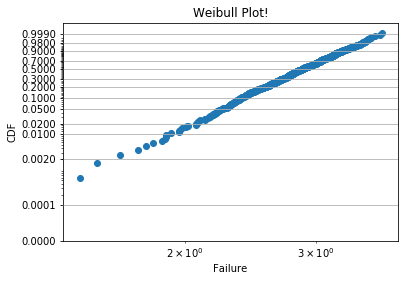

In [32]:

from __future__ import unicode_literals

import numpy as np
from scipy.stats.distributions import weibull_min
from scipy.stats.mstats import plotting_positions as pp
from numpy import ma
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator, AutoLocator, LinearLocator
from matplotlib import rcParams

import numpy as np
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import FormatStrFormatter, FixedLocator
from scipy.stats import norm


# BUG: this example fails with any other setting of axisbelow
rcParams['axes.axisbelow'] = False

class WeibullScale(mscale.ScaleBase):
    """
    Scales data in range 0 to 100 using a non-standard log transform
    This scale attempts to replicate "probability paper" scaling

    The scale function:
        A piecewise combination of exponential, linear, and logarithmic scales

    The inverse scale function:
      piecewise combination of exponential, linear, and logarithmic scales

    Since probabilities at 0 and 100 are not represented,
    there is user-defined upper and lower limit, above and below which nothing
    will be plotted.  This defaults to .1 and 99 for lower and upper, respectively.

    """

    # The scale class must have a member ``name`` that defines the
    # string used to select the scale.  For example,
    # ``gca().set_yscale("mercator")`` would be used to select this
    # scale.
    name = 'weibull'

    def __init__(self, axis, **kwargs):
        """
        Any keyword arguments passed to ``set_xscale`` and
        ``set_yscale`` will be passed along to the scale's
        constructor.

        upper: The probability above which to crop the data.
        lower: The probability below which to crop the data.
        """
        mscale.ScaleBase.__init__(self)
        upper = kwargs.pop("upper", 0.999999) 
        lower = kwargs.pop("lower", 1e-5)
        
        if upper <= 0 or upper >= 1:
            raise ValueError("upper must be between 0 and 1.")
        if lower <= 0 or lower >= 1:
            raise ValueError("lower must be between 0 and 1.")
        if lower >= upper:
            raise ValueError("lower must be strictly less than upper!.")
        self.lower = lower
        self.upper = upper

        #This scale is best described by the CDF of the normal distribution
        #This distribution is paramaterized by mu and sigma, these default vaules
        #are provided to work generally well, but can be adjusted by the user if desired
        #Need to enfore the upper and lower limits on the axes initially
        axis.axes.set_ylim(lower, upper)

    def get_transform(self):
        """
        Override this method to return a new instance that does the
        actual transformation of the data.

        The ProbTransform class is defined below as a
        nested class of this one.
        """
        return self.WeibullTransform()

    def set_default_locators_and_formatters(self, axis):
        """
        Override to set up the locators and formatters to use with the
        scale.  This is only required if the scale requires custom
        locators and formatters.  Writing custom locators and
        formatters: many helpful examples in ``ticker.py``.

        In this case, the prob_scale uses a fixed locator from
        0.1 to 99 % and a custom no formatter class

        This builds both the major and minor locators, and cuts off any values
        above or below the user defined thresholds: upper, lower
        """
        major_ticks = np.asarray([0.001, 0.01, .2,1,2,5,10,20,30,
                                  50,70,90,98,99.9])/100
        major_ticks = major_ticks[np.where((major_ticks >= self.lower) & 
                                           (major_ticks <= self.upper))]

        minor_ticks = np.concatenate([np.arange(.02, .1, .01),
                                      np.arange(.2, 1, .1),
                                      np.arange(1, 2, .2), 
                                      np.arange(2, 20,1), 
                                      np.arange(20, 80, 2), 
                                      np.arange(80, 98, 1),
                                      np.arange(98, 99.999, .5)] )/100
        minor_ticks = minor_ticks[np.where((minor_ticks >= self.lower) & 
                                          (minor_ticks <= self.upper))]
        axis.set_major_locator(FixedLocator(major_ticks))
        axis.set_minor_locator(FixedLocator(minor_ticks))
        

    def limit_range_for_scale(self, vmin, vmax, minpos):
        """
        Override to limit the bounds of the axis to the domain of the
        transform.
        """
        print(vmin, vmax)
        return vmin, vmax

    class WeibullTransform(mtransforms.Transform):
        # There are two value members that must be defined.
        # ``input_dims`` and ``output_dims`` specify number of input
        # dimensions and output dimensions to the transformation.
        # These are used by the transformation framework to do some
        # error checking and prevent incompatible transformations from
        # being connected together.  When defining transforms for a
        # scale, which are, by definition, separable and have only one
        # dimension, these members should always be set to 1.
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self):
            mtransforms.Transform.__init__(self)
            

        def transform_non_affine(self, x):
            """
            This transform takes an Nx1 ``numpy`` array and returns a
            transformed copy.  Since the range of the Probability scale
            is limited by the user-specified threshold, the input
            array must be masked to contain only valid values.
            ``matplotlib`` will handle masked arrays and remove the
            out-of-range data from the plot.  Importantly, the
            ``transform`` method *must* return an array that is the
            same shape as the input array, since these values need to
            remain synchronized with values in the other dimension.
            """

            #Get the CDF of the normal distribution located at mu and scaled by sigma
            #Multiply these by 100 to put it into a percent scale
            
            mask = (x <= 0.0) | (x >= 1.0)
            if mask.any():
                x = np.where(mask, np.nan, x)
            return np.log(np.log(1/(1 - x)))

        def inverted(self):
            """
            Override this method so matplotlib knows how to get the
            inverse transform for this transform.
            """
            return WeibullScale.InvertedWeibullTransform()

    class InvertedWeibullTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            #Need to get the PPF value for a, which is in a percent scale [0,100], so move back to probability range [0,1]
            inverse = 1. - 1./np.exp(np.exp(a))
            return inverse

        def inverted(self):
            return WeibullScale.WeibullTransform()

# Now that the Scale class has been defined, it must be registered so
# that ``matplotlib`` can find it.
mscale.register_scale(WeibullScale)


# Now that the Scale class has been defined, it must be registered so
# that ``matplotlib`` can find it.
#mscale.register_scale(WeibullScale)


if __name__ == '__main__':
    import matplotlib.pyplot as plt

    x = np.sort(weibull_min.rvs(10, scale=3, size=1000))
    y = np.array(pp(x))

    plt.scatter(x, y)
    plt.gca().set_yscale('weibull')
    plt.gca().set_xscale('log')

    plt.xlabel('Failure')
    plt.ylabel('CDF')
    plt.title('Weibull Plot!')
    plt.grid(True)

    plt.show()


For these anlyses, we will go back to the beinging and use Weibull's original yield strength of bofors steel data. This is the yield strength, measured in (oddly) 1.275 kg/mm^2 and the number of observations.

In [3]:
x = np.array([32, 33, 34, 35, 36, 37, 38, 39, 40, 42])
n = np.array([10, 33, 81, 161, 224, 289, 336, 369, 383, 389])

# Mr Weibull's measurements are cumulative, so let's calculate the obervations at each point.
n = np.concatenate([[n[0]], np.diff(n)])

In [4]:
R = nonp.nelson_aalen(x, n=n)

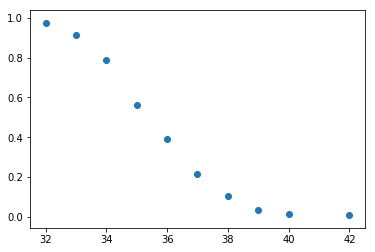

In [6]:
ax = plt.scatter(x, 1-R)

In [7]:
R_km = nonp.nelson_aalen(x, n=n)

ValueError: x and y must be the same size

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in true_divide


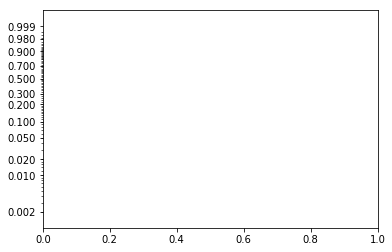

In [17]:
plt.yscale('weibull')
ax = plt.scatter(x, R_km)

In [9]:
import WeibullScale

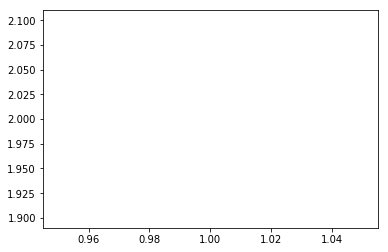

In [12]:
plt.plot([1], [2])